# Case Study: Home Credit Default Risk Prediction

This case study demonstrates a complete machine learning pipeline to preprocess data, train a model, and predict values for the [Home Credit Default Risk](https://www.kaggle.com/competitions/home-credit-default-risk/) Kaggle competition.


## Introduction

This is a binary Classification task: we want to predict whether the person applying for a home credit will be able to repay their debt or not. Our model will have to predict a 1 indicating the client will have payment difficulties: he/she will have late payment of more than X days on at least one of the first Y installments of the loan in our sample, 0 in all other cases.

The dataset is composed of multiple files with different information about loans taken. In this project, we will work exclusively with the primary files: `application_train_aai.csv` and `application_test_aai.csv`.

We will use [Area Under the ROC Curve](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc?hl=es_419) as the evaluation metric, so our models will have to return the probabilities that a loan is not paid for each row.

In [8]:
# Import libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.validation import check_is_fitted

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src import config, data_utils, preprocessing

### Getting the Data

The following code block downloads the necessary dataset files into the `dataset` folder:

- `application_train_aai.csv`: The training dataset used to train the model and find the best hyperparameters.

- `application_test_aai.csv`: The test dataset, without labels. This file is used at the end to generate predictions with the final model.

- `HomeCredit_columns_description.csv`: This file contains descriptions for the columns in the train and test datasets.


#### Loading the Datasets

The training, test, and column description datasets are loaded into pandas DataFrames.

In [9]:
app_train, app_test, columns_description = data_utils.get_datasets()


if app_train.shape == (246008, 122):
    print("Success: app_train shape is correct!")
else:
    raise ValueError("Train dataset shape is incorrect, please review your code")

if isinstance(app_train, pd.DataFrame):
    print("Success: app_train type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

if app_test.shape == (61503, 122):
    print("Success: app_test shape is correct!")
else:
    raise ValueError("Test dataset shape is incorrect, please review your code")

if isinstance(app_test, pd.DataFrame):
    print("Success: app_test type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

Success: app_train shape is correct!
Success: app_train type is correct!
Success: app_test shape is correct!
Success: app_test type is correct!


### Exploratory Data Analysis

Before preprocessing the data, a thorough exploratory data analysis (EDA) was conducted to understand the properties of the dataset. While much analysis is publicly available, this step is crucial for building an effective model.

#### Dataset Basics

The number of samples in the train and test datasets are printed below.

In [10]:
print(f"Train samples: {app_train.shape[0]}")
print(f"Test samples: {app_test.shape[0]}")

Train samples: 246008
Test samples: 61503


A list of all columns in the training dataset.

In [11]:
pd.set_option('display.max_columns', None)
print(app_train.columns.tolist())

['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELE

A transposed view of the first 5 records allows for a detailed examination of the features for each sample.

In [12]:
pd.set_option('display.max_columns', None)
app_train.head().T

,0,1,2,3,4
SK_ID_CURR,428247,140966,407283,434300,446788
TARGET,0,0,0,0,0
NAME_CONTRACT_TYPE,Cash loans,Cash loans,Revolving loans,Cash loans,Cash loans
CODE_GENDER,F,M,F,F,F
FLAG_OWN_CAR,N,Y,N,N,N
...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,NaN,0.0,0.0,0.0,0.0
AMT_REQ_CREDIT_BUREAU_WEEK,NaN,0.0,0.0,0.0,0.0
AMT_REQ_CREDIT_BUREAU_MON,NaN,0.0,0.0,0.0,0.0
AMT_REQ_CREDIT_BUREAU_QRT,NaN,0.0,0.0,1.0,0.0


The distribution of the target variable is shown below. This reveals an imbalanced dataset, which is common in default prediction problems.

   Target Value   Count
0             0  226257
1             1   19751
   Target Value   Count  Percentage
0             0  226257   91.971399
1             1   19751    8.028601


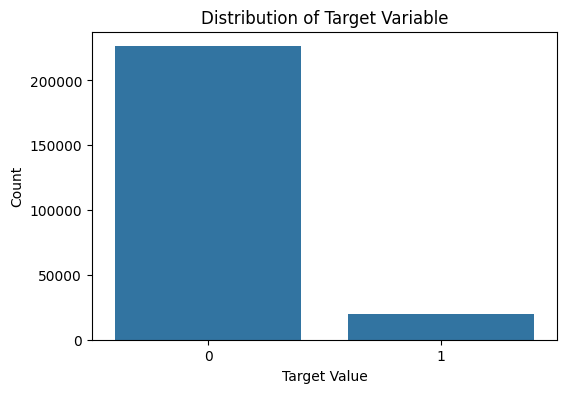

In [13]:
temp = app_train['TARGET'].value_counts()
df = pd.DataFrame({'Target Value': temp.index, 'Count': temp.values})
print(df)

# Calculate percentages
total_count = temp.sum()
percentages = (temp / total_count) * 100
df['Percentage'] = percentages.values
print(df)

plt.figure(figsize=(6, 4))
sns.barplot(x='Target Value', y='Count', data=df)
plt.title('Distribution of Target Variable')
plt.xlabel('Target Value')
plt.ylabel('Count')
plt.show()

The number of columns for each data type is displayed below.

In [14]:
print(app_train.dtypes.value_counts())

float64    65
int64      41
object     16
Name: count, dtype: int64


For categorical variables (`object` data type), we examine the number of distinct values in each column.

In [15]:
app_train.select_dtypes('object').nunique()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

#### Analyzing Missing Data
The percentage of missing data for the top 20 columns with the highest number of missing values is shown below. This is a critical step for determining an appropriate imputation strategy.

In [16]:
def missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)
    missing_app_train_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_app_train_data.head(20)

missing_data(app_train)

,Total,Percent
COMMONAREA_AVG,172189,69.993252
COMMONAREA_MODE,172189,69.993252
COMMONAREA_MEDI,172189,69.993252
NONLIVINGAPARTMENTS_MEDI,171096,69.548958
NONLIVINGAPARTMENTS_MODE,171096,69.548958
NONLIVINGAPARTMENTS_AVG,171096,69.548958
FONDKAPREMONT_MODE,168561,68.518503
LIVINGAPARTMENTS_AVG,168494,68.491269
LIVINGAPARTMENTS_MEDI,168494,68.491269
LIVINGAPARTMENTS_MODE,168494,68.491269


#### Analyzing Variable Distributions

The distribution of credit amounts (`AMT_CREDIT`) is visualized below.

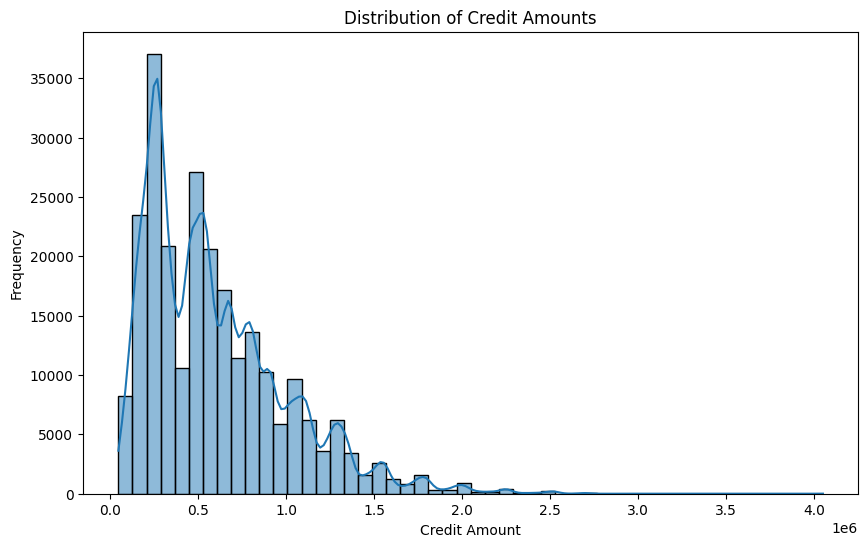

In [18]:
plt.figure(figsize=(10, 6))
sns.histplot(app_train['AMT_CREDIT'], bins=50, kde=True)
plt.title('Distribution of Credit Amounts')
plt.xlabel('Credit Amount')
plt.ylabel('Frequency')
plt.show()

Next, we plot the education level of the credit applicants, showing the percentages of each category along with the total counts.

Education Level Counts:
NAME_EDUCATION_TYPE
Secondary / secondary special    174657
Higher education                  59990
Incomplete higher                  8248
Lower secondary                    2984
Academic degree                     129
Name: count, dtype: int64
Education Level Percentages:
NAME_EDUCATION_TYPE
Secondary / secondary special    70.996472
Higher education                 24.385386
Incomplete higher                 3.352736
Lower secondary                   1.212969
Academic degree                   0.052437
Name: proportion, dtype: float64


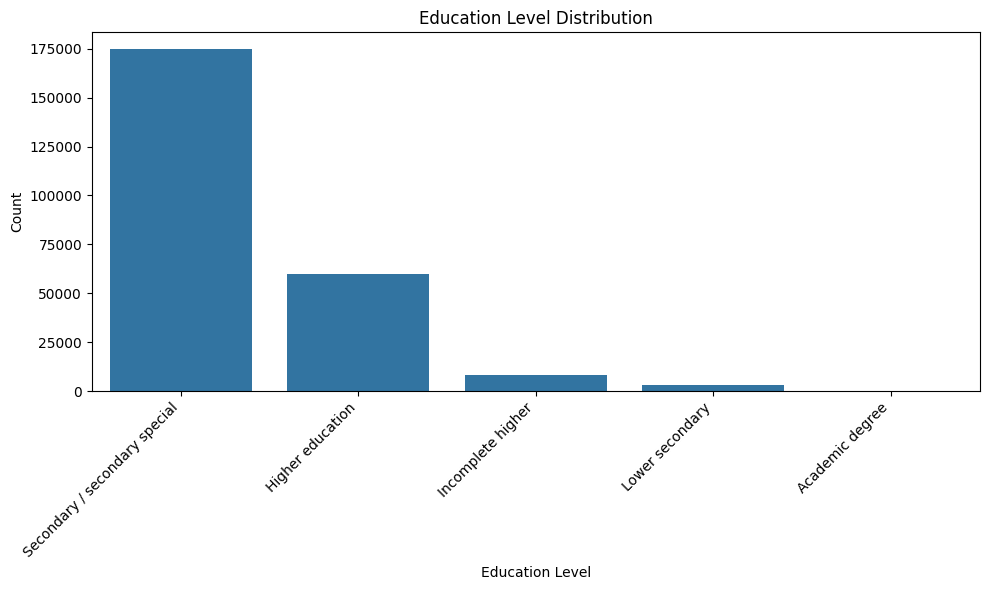

In [20]:
education_counts = app_train["NAME_EDUCATION_TYPE"].value_counts()
education_percentages = app_train["NAME_EDUCATION_TYPE"].value_counts(normalize=True) * 100

print("Education Level Counts:")
print(education_counts)
print("Education Level Percentages:")
print(education_percentages)

plt.figure(figsize=(10, 6))
sns.barplot(x=education_counts.index, y=education_counts.values)
plt.title("Education Level Distribution")
plt.xlabel("Education Level")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

The distribution of the occupation of the loan applicants is plotted to understand the professional background of the applicants.

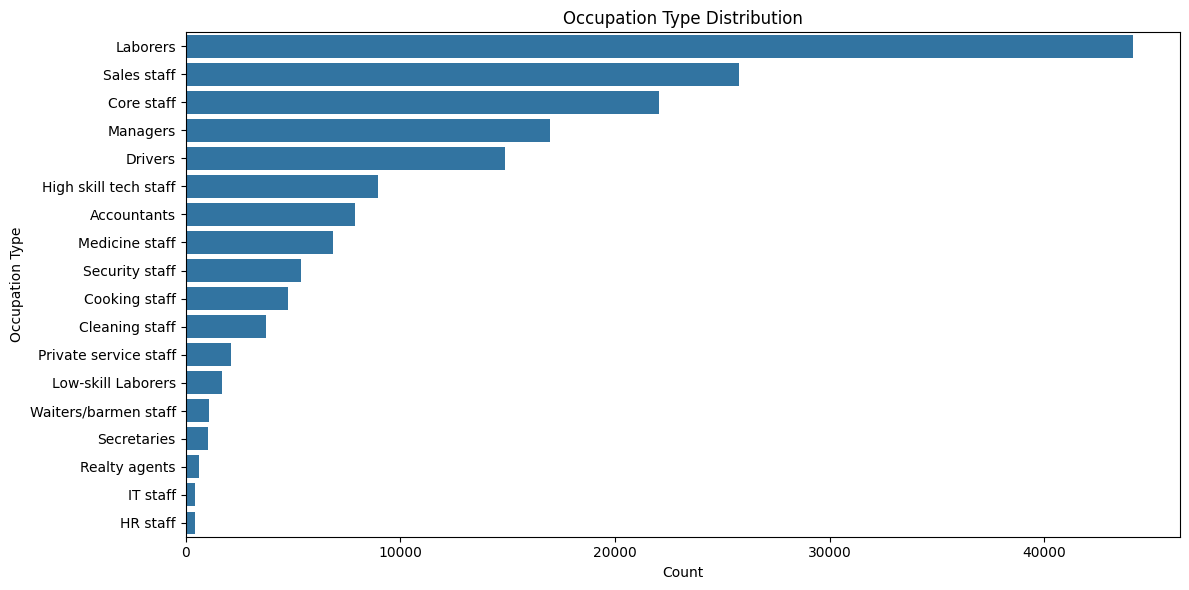

In [21]:
plt.figure(figsize=(12, 6))
sns.countplot(data=app_train, y='OCCUPATION_TYPE', order=app_train['OCCUPATION_TYPE'].value_counts().index)
plt.title('Occupation Type Distribution')
plt.xlabel('Count')
plt.ylabel('Occupation Type')
plt.tight_layout()
plt.show()

The family status of the applicants is plotted to see the distribution of marital statuses.

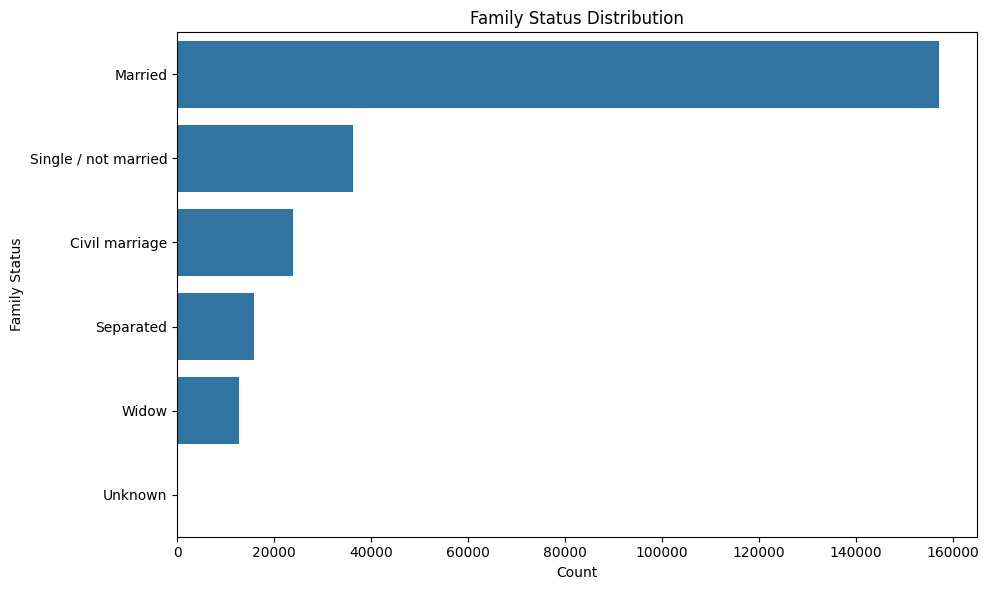

In [22]:
plt.figure(figsize=(10, 6))
sns.countplot(data=app_train, y='NAME_FAMILY_STATUS', order=app_train['NAME_FAMILY_STATUS'].value_counts().index)
plt.title('Family Status Distribution')
plt.xlabel('Count')
plt.ylabel('Family Status')
plt.tight_layout()
plt.show()

Here, we plot the income type of applicants, grouped by the target variable. This helps to see if there is a relationship between income type and the likelihood of default.

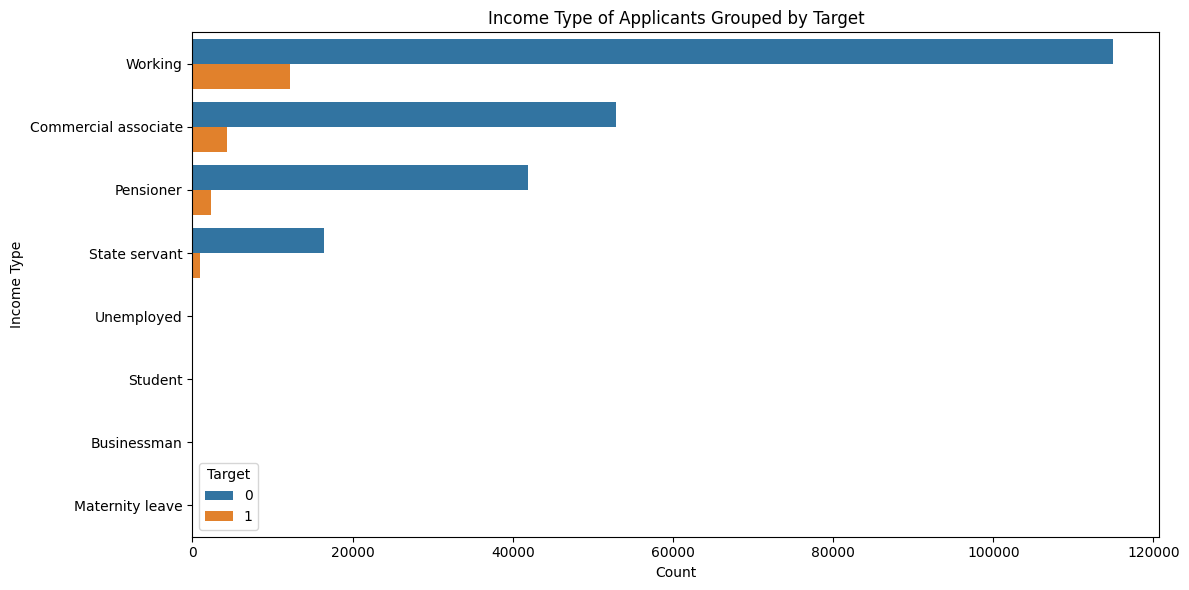

In [23]:
plt.figure(figsize=(12, 6))
sns.countplot(data=app_train, y='NAME_INCOME_TYPE', hue='TARGET', order=app_train['NAME_INCOME_TYPE'].value_counts().index)
plt.title('Income Type of Applicants Grouped by Target')
plt.xlabel('Count')
plt.ylabel('Income Type')
plt.legend(title='Target')
plt.tight_layout()
plt.show()

## 2. Preprocessing

### Feature and Target Separation

The next step is to separate the columns of our train and test datasets into features (the input to the model) and targets (what the model has to predict).

- `X_train`: All columns from `app_train` to be used as features for training.
- `y_train`: The target column from `app_train`.
- `X_test`: All columns from `app_test` to be used as features for prediction.
- `y_test`: The target column from `app_test`.

This is accomplished by the `data_utils.get_feature_target()` function.

In [24]:
# Now we execute the function above to get the result
X_train, y_train, X_test, y_test = data_utils.get_feature_target(app_train, app_test)


if X_train.shape == (246008, 121):
    print("Success: X_train shape is correct!")
else:
    raise ValueError("X_train dataset shape is incorrect, please review your code")

if isinstance(X_train, pd.DataFrame):
    print("Success: X_train type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

if y_train.shape == (246008,) or y_train.shape == (246008, 1):
    print("Success: y_train shape is correct!")
else:
    raise ValueError("Train labels shape is incorrect, please review your code")

if X_test.shape == (61503, 121):
    print("Success: X_test shape is correct!")
else:
    raise ValueError("Test dataset shape is incorrect, please review your code")

if isinstance(X_test, pd.DataFrame):
    print("Success: X_test type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

if y_test.shape == (61503,) or y_test.shape == (61503, 1):
    print("Success: y_test shape is correct!")
else:
    raise ValueError("Test labels shape is incorrect, please review your code")

Success: X_train shape is correct!
Success: X_train type is correct!
Success: y_train shape is correct!
Success: X_test shape is correct!
Success: X_test type is correct!
Success: y_test shape is correct!


### Train-Validation Split

To avoid overfitting while searching for the best model hyperparameters, the training dataset is split into `train` and `validation` sets. The `train` set is used to fit the model, while the `validation` set is used to evaluate its performance on unseen data during experimentation. The `test` set is reserved for the final evaluation of the model.

The `data_utils.get_train_val_sets()` function performs this split using `sklearn.model_selection.train_test_split`, with 20% of the data allocated for validation.

In [25]:
# Now we execute the function above to get the result
X_train, X_val, y_train, y_val = data_utils.get_train_val_sets(X_train, y_train)


if X_train.shape == (196806, 121):
    print("Success: X_train shape is correct!")
else:
    raise ValueError("X_train dataset shape is incorrect, please review your code")

if isinstance(X_train, pd.DataFrame):
    print("Success: X_train type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

if y_train.shape == (196806,) or y_train.shape == (196806, 1):
    print("Success: y_train shape is correct!")
else:
    raise ValueError("Train labels shape is incorrect, please review your code")

if X_val.shape == (49202, 121):
    print("Success: X_test shape is correct!")
else:
    raise ValueError("Test dataset shape is incorrect, please review your code")

if isinstance(X_val, pd.DataFrame):
    print("Success: X_test type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

if y_val.shape == (49202,) or y_val.shape == (49202, 1):
    print("Success: y_test shape is correct!")
else:
    raise ValueError("Test labels shape is incorrect, please review your code")

Success: X_train shape is correct!
Success: X_train type is correct!
Success: y_train shape is correct!
Success: X_test shape is correct!
Success: X_test type is correct!
Success: y_test shape is correct!


### Data Preprocessing Function

The `preprocessing.preprocess_data()` function performs all data preprocessing. This function takes the `X_train`, `X_val`, and `X_test` dataframes and returns the transformed data as numpy arrays. The steps are as follows:

1.  **Correct Outliers:** Anomalous values in the `DAYS_EMPLOYED` column are corrected.
2.  **Encode Categorical Features:** String categorical features (`object` dtype) are encoded. Binary features are binary encoded, and multi-category features are one-hot encoded.
3.  **Impute Missing Values:** Missing data in all columns is imputed using the median.
4.  **Feature Scaling:** A Min-Max scaler is applied to the features.

The preprocessing function is executed in the following cell. The resulting `train_data`, `val_data`, and `test_data` will be used in the subsequent modeling steps.

In [30]:
train_data, val_data, test_data = preprocessing.preprocess_data(X_train, X_val, X_test)


# if train_data.shape == (196806, 246):
#     print("Success: train_data shape is correct!")
# else:
#     raise ValueError("train_data dataset shape is incorrect, please review your code")

if isinstance(train_data, np.ndarray):
    print("Success: train_data type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

# if val_data.shape == (49202, 246):
#     print("Success: val_data shape is correct!")
# else:
#     raise ValueError("val_data dataset shape is incorrect, please review your code")

if isinstance(val_data, np.ndarray):
    print("Success: val_data type is correct!")
else:
    raise ValueError("Validation dataset type is incorrect, please review your code")

# if test_data.shape == (61503, 246):
#     print("Success: test_data shape is correct!")
# else:
#     raise ValueError("test_data dataset shape is incorrect, please review your code")

if isinstance(test_data, np.ndarray):
    print("Success: test_data type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

d:\VSCode\python\AnyoneAI\Sprint 2\src\preprocessing.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)


Success: train_data type is correct!
Success: val_data type is correct!
Success: test_data type is correct!


## 3. Model Training

The modeling process begins with simple models and progressively moves to more complex ones. The training time for each model is measured to provide an estimate of the computational cost.

### Baseline: Logistic Regression

A Logistic Regression model is trained as a baseline using the preprocessed training data and default parameters. The trained model is assigned to the `log_reg` variable.

In [27]:
%%time

# This is an example code on how to:
#   - Create and fit (train) a logistic regression
#   - Assign to `log_reg` variable
log_reg = None
log_reg = LogisticRegression(C=0.0001)
log_reg.fit(train_data, y_train)

CPU times: total: 6.73 s
Wall time: 1.75 s


,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.0001
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [31]:
if isinstance(log_reg, LogisticRegression):
    print("Success: Logistic regression model type is correct!")
else:
    raise ValueError(
        "Logistic regression model type is incorrect, please review your code"
    )

check_is_fitted(log_reg)

Success: Logistic regression model type is correct!


The trained model is used to predict probabilities for the `train_data` and `val_data`. For computing the AUC ROC score, only the probabilities for class 1 (indicating default) are needed.

In [32]:
# Example code to show you how to use the Logistic Regression model
# to predict probabilities for each class and then, use the probabilities for the
# class 1 only.

# Train data predictions (class 1)
log_reg_train = log_reg.predict_proba(train_data)[:, 1]

# Validation data predictions (class 1)
log_reg_val = log_reg.predict_proba(val_data)[:, 1]

The AUC ROC score is calculated for both the train and validation datasets to evaluate the model's performance.

In [33]:
# Example code to show you how to get the ROC AUC Score on train and val datasets

# Train ROC AUC Score
roc_auc_train = roc_auc_score(y_true=y_train, y_score=log_reg_train)
print(f"Train ROC AUC Score: {roc_auc_train:.4f}")

# Validation ROC AUC Score
roc_auc_val = roc_auc_score(y_true=y_val, y_score=log_reg_val)
print(f"Validation ROC AUC Score: {roc_auc_val:.4f}")

Train ROC AUC Score: 0.6941
Validation ROC AUC Score: 0.6921


The baseline model achieves a score of around 0.69. The similar performance on both train and validation sets suggests that the model is not overfitting.

In [34]:
if isinstance(roc_auc_val, float):
    print("Success: AUC ROC score type is correct!")
else:
    raise ValueError("AUC ROC score type is incorrect, please review your code")

if roc_auc_val >= 0.6:
    print("Success: AUC ROC score is correct!")
else:
    raise ValueError("AUC ROC score is incorrect, please review your code")

Success: AUC ROC score type is correct!
Success: AUC ROC score is correct!


### Random Forest Classifier

Next, we move to a more complex model: the Random Forest Classifier from Scikit-Learn.

A Random Forest Classifier is trained with default hyperparameters, except for `n_jobs`, which is set to -1 to utilize all available CPU cores.

In [35]:
%%time

# TODO Write your code here for training a Random Forest model.
#   - Please use sklearn.ensemble.RandomForestClassifier() class.
#   - Assign the model to the variable `rf`.
#   - Remember to fit the model only on `train_data`.
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(train_data, y_train)

CPU times: total: 3min 1s
Wall time: 32.7 s


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [36]:
if isinstance(rf, RandomForestClassifier):
    print("Success: RandomForestClassifier model type is correct!")
else:
    raise ValueError(
        "RandomForestClassifier model type is incorrect, please review your code"
    )

check_is_fitted(rf)

Success: RandomForestClassifier model type is correct!


The trained classifier is used to predict probabilities for the train and validation data.

In [37]:
# TODO Use the Random Forest model to predict probabilities for each class and then,
# use the probabilities for the class 1 only.

# Train data predictions (class 1)
rf_pred_train = rf.predict_proba(train_data)[:, 1]

# Validation data predictions (class 1)
rf_pred_val = rf.predict_proba(val_data)[:, 1]

The AUC ROC score is calculated for both the train and validation datasets.

In [38]:
# TODO Get the ROC AUC Score on train_data and val_data datasets.
# Train ROC AUC Score
roc_auc_train = roc_auc_score(y_true=y_train, y_score=rf_pred_train)
print(f"Train ROC AUC Score: {roc_auc_train:.4f}")

# Validation ROC AUC Score
roc_auc_val = roc_auc_score(y_true=y_val, y_score=rf_pred_val)
print(f"Validation ROC AUC Score: {roc_auc_val:.4f}")

Train ROC AUC Score: 1.0000
Validation ROC AUC Score: 0.7122


The model achieves a perfect score on the training data, but a much lower score on the validation data. This is a clear sign of overfitting.

### Hyperparameter Tuning with Randomized Search

To address the overfitting observed in the previous model, hyperparameter tuning is performed. Instead of a full grid search, which can be computationally expensive, a Randomized Search with K-Fold Cross-Validation is used to efficiently search for a better combination of hyperparameters.

We use `sklearn.model_selection.RandomizedSearchCV()` to find the best combination of hyperparameters for a Random Forest model, using "roc_auc" as the scoring metric.

In [42]:
%%time

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    "n_estimators": [100, 200, 300, 400, 500],
    "max_features": ["auto", "sqrt", "log2"],
    "max_depth": [10, 20, 30, 40, 50, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False]
}

# Create a RandomForestClassifier model
rf_base = RandomForestClassifier(n_jobs=-1)

# Create the RandomizedSearchCV object
rf_random = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=10,  # Number of parameter settings that are sampled
    cv=3,  # Number of folds for cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='roc_auc'
)

# Fit the RandomizedSearchCV object to the training data
rf_random.fit(train_data, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


d:\VSCode\python\AnyoneAI\Sprint 2\env\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
6 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "d:\VSCode\python\AnyoneAI\Sprint 2\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\VSCode\python\AnyoneAI\Sprint 2\env\Lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "d:\VSCode\python\AnyoneAI\Sprint 2\env\Lib\site-package

CPU times: total: 1min 48s
Wall time: 21min 45s


,estimator,RandomForestC...ier(n_jobs=-1)
,param_distributions,"{'bootstrap': [True, False], 'max_depth': [10, 20, ...], 'max_features': ['auto', 'sqrt', ...], 'min_samples_leaf': [1, 2, ...], ...}"
,n_iter,10
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


The classifier with the best-found hyperparameters is then used to predict probabilities on the train and validation data.

In [43]:
# TODO Use the RandomizedSearchCV model to predict probabilities for each class and
# then, use the probabilities for the class 1 only.

# Train data predictions (class 1)
rf_tuned_pred_train = rf_random.predict_proba(train_data)[:, 1]

# Validation data predictions (class 1)
rf_tuned_pred_val = rf_random.predict_proba(val_data)[:, 1]

The AUC ROC score is calculated for the tuned model.

In [44]:
# TODO Get the ROC AUC Score on train_data and val_data datasets.
# Train ROC AUC Score
roc_auc_train = roc_auc_score(y_true=y_train, y_score=rf_tuned_pred_train)
print(f"Train ROC AUC Score: {roc_auc_train:.4f}")

# Validation ROC AUC Score
roc_auc_val = roc_auc_score(y_true=y_val, y_score=rf_tuned_pred_val)
print(f"Validation ROC AUC Score: {roc_auc_val:.4f}")

Train ROC AUC Score: 0.8200
Validation ROC AUC Score: 0.7397


After hyperparameter tuning, the validation score has improved, and the gap between the train and validation scores has narrowed, indicating that overfitting has been reduced.

## 4. Generating Predictions on Unlabeled Data

Finally, the best performing model is used to generate predictions on the unlabeled `test_data`. The predictions (probabilities for class 1) are saved in the `TARGET` column of the `app_test` DataFrame, which is then saved to a CSV file for submission.

In [45]:
%%time

# Use the best estimator from RandomizedSearchCV
best_credit_model_ever = rf_random.best_estimator_

test_preds = best_credit_model_ever.predict_proba(test_data)[:, 1]
app_test["TARGET"] = test_preds
app_test.to_csv(config.DATASET_TEST, index=False)

CPU times: total: 4.16 s
Wall time: 3.44 s


## 5. Further Analysis

### LightGBM Model Exploration

Gradient Boosting Machine is one of the most used machine learning algorithms for tabular data. Many competitions have been won using models from libraries like XGBoost or LightGBM. Here, a [LightGBM](https://lightgbm.readthedocs.io/en/latest/) model is trained to compare its performance against the other classifiers.

In [48]:
import lightgbm as lgb

lgb_clf = lgb.LGBMClassifier(objective='binary',
                           metric='auc',
                           n_estimators=1000,
                           learning_rate=0.05,
                           num_leaves=30,
                           max_depth=5,
                           min_child_samples=20,
                           subsample=0.8,
                           colsample_bytree=0.8,
                           random_state=42,
                           n_jobs=-1)

lgb_clf.fit(train_data, y_train, eval_set=[(val_data, y_val)])

,boosting_type,'gbdt'
,num_leaves,30
,max_depth,5
,learning_rate,0.05
,n_estimators,1000
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


### Streamlining with Scikit-Learn Pipelines 

To ensure reproducibility and simplify the workflow, a [Sklearn Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) is used to chain the data preprocessing and modeling steps. This approach avoids the need for manual step-by-step execution for new data.

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

# Identify categorical and numerical columns
numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
]) 

# Preprocessing for categorical data
# Binary columns (assuming 2 unique values)
binary_cols_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder())
]) 

# Multi-category columns
multi_cols_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
]) 

# Create a preprocessor object using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat_binary', binary_cols_pipeline, [col for col in categorical_cols if X_train[col].nunique() == 2]),
        ('cat_multi', multi_cols_pipeline, [col for col in categorical_cols if X_train[col].nunique() > 2])
]) 

# Create the full pipeline with a classifier (e.g., RandomForestClassifier)
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', RandomForestClassifier(n_jobs=-1, random_state=42))])

# Fit the pipeline
model_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat_binary', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Custom Model and Feature Engineering

This section explores custom feature engineering and model tuning. The original labeled data is used to create new features, preprocess the data, and tune the model. This allows for a more creative and in-depth approach to improving model performance.

In [6]:
# ---------- Imports ----------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, KBinsDiscretizer
from lightgbm import LGBMClassifier, early_stopping
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression


# ---------- Feature Engineering ----------
def add_features(df):
    df = df.copy()
    eps = 1e-5

    df['ANNUITY_INCOME_RATIO'] = df['AMT_ANNUITY'] / (df['AMT_INCOME_TOTAL'] + eps)
    df['CREDIT_INCOME_RATIO'] = df['AMT_CREDIT'] / (df['AMT_INCOME_TOTAL'] + eps)
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / (df['CNT_FAM_MEMBERS'] + eps)
    df['CREDIT_PER_PERSON'] = df['AMT_CREDIT'] / (df['CNT_FAM_MEMBERS'] + eps)
    df['CREDIT_ANNUITY_RATIO'] = df['AMT_CREDIT'] / (df['AMT_ANNUITY'] + eps)
    df['CREDIT_GOODS_DIFF'] = df['AMT_CREDIT'] - df['AMT_GOODS_PRICE']
    df['EXT_SOURCES_AVG'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    df['EXT_SOURCES_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    df['EXT_SOURCE_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['EXT_SOURCE_NAN_COUNT'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].isna().sum(axis=1)
    df['ANNUITY_EXT_MEAN'] = df['AMT_ANNUITY'] * df['EXT_SOURCES_AVG']
    df['EXT_SOURCE_WEIGHTS'] = 2 * df['EXT_SOURCE_2'] + df['EXT_SOURCE_3']
    df['LOG_INCOME'] = np.log1p(df['AMT_INCOME_TOTAL'])
    df['LOG_CREDIT'] = np.log1p(df['AMT_CREDIT'])
    df['REGION_DIFF'] = df['REGION_RATING_CLIENT'] - df['REGION_RATING_CLIENT_W_CITY']
    df['REGISTRATION_TO_APPLICATION'] = df['DAYS_REGISTRATION'] - df['DAYS_ID_PUBLISH']
    df['EMPLOYED_AGE_RATIO'] = df['DAYS_EMPLOYED'] / (df['DAYS_BIRTH'] + eps)
    df['AGE_YEARS'] = -df['DAYS_BIRTH'] / 365
    df['YEARS_EMPLOYED'] = -df['DAYS_EMPLOYED'].clip(upper=0) / 365
    df['CHANGE_PHONE_DAYS'] = np.abs(df['DAYS_LAST_PHONE_CHANGE'])
    df['DOCUMENT_COUNT'] = df.filter(like='FLAG_DOCUMENT_').sum(axis=1)
    df['NUM_OBS_CONTACT'] = df['OBS_30_CNT_SOCIAL_CIRCLE'] + df['DEF_30_CNT_SOCIAL_CIRCLE']
    df['HOUSING_DENSITY'] = df['CNT_CHILDREN'] / (df['CNT_FAM_MEMBERS'] + eps)
    df['HAS_HOUSING'] = df['FLAG_OWN_REALTY'].map({'Y': 1, 'N': 0})
    df['CREDIT_TERM'] = df['AMT_ANNUITY'] / (df['AMT_GOODS_PRICE'] + eps)

    # Interaction features
    df['CREDIT_X_EXT_AVG'] = df['AMT_CREDIT'] * df['EXT_SOURCES_AVG']
    df['INCOME_LOG_X_EXT_MEAN'] = df['LOG_INCOME'] * df['EXT_SOURCES_AVG']

    # Quantile binning of EXT_SOURCEs
    
    return df

# ---------- Preprocessing ----------
def clean_feature_names(df):
    df.columns = df.columns.str.replace(r'[\"\':{},\[\]\\]', '', regex=True)
    return df

def clean_and_encode(df, cat_encoders, fit=True):
    if fit:
        binary_cols = [col for col in df.select_dtypes(include='object') if df[col].nunique() == 2]
        multi_cols = [col for col in df.select_dtypes(include='object') if df[col].nunique() > 2]
        cat_encoders = {
            'ordinal': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1).fit(df[binary_cols]) if binary_cols else None,
            'onehot': OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(df[multi_cols]) if multi_cols else None,
            'binary_cols': binary_cols,
            'multi_cols': multi_cols
        }
    else:
        binary_cols = cat_encoders['binary_cols']
        multi_cols = cat_encoders['multi_cols']

    if binary_cols and cat_encoders['ordinal'] is not None:
        df.loc[:, binary_cols] = cat_encoders['ordinal'].transform(df[binary_cols])

    if multi_cols and cat_encoders['onehot'] is not None:
        onehot_df = pd.DataFrame(
            cat_encoders['onehot'].transform(df[multi_cols]),
            columns=cat_encoders['onehot'].get_feature_names_out(multi_cols),
            index=df.index
        )
        df = df.drop(columns=multi_cols)
        df = pd.concat([df, onehot_df], axis=1)

    return clean_feature_names(df), cat_encoders

def impute_data(df, imputer=None, fit=True):
    if fit:
        imputer = SimpleImputer(strategy='median').fit(df)
    df.loc[:, :] = imputer.transform(df)
    return df, imputer

def add_binned_ext_sources(
    df,
    cols=['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'],
    max_bins=5,
    clip_lower=1e-4,
    min_var=1e-6
):
    """
    Bins EXT_SOURCE_* columns using adaptive quantile binning.
    Assigns -1 to rows excluded from binning due to filtering.
    """


    df = df.copy()
    for col in cols:
        if col not in df.columns:
            continue

        # Skip if variance too low
        if df[col].var(skipna=True) < min_var:
            continue

        # Filter and clip values
        valid_vals = df[col].dropna()
        valid_vals = valid_vals[valid_vals > clip_lower]

        # Skip if too few values left
        if len(valid_vals) < 30:
            continue

        # Adjust bin count based on uniqueness
        bin_count = min(max_bins, max(2, int(valid_vals.nunique() / 2)))

        binner = KBinsDiscretizer(
            n_bins=bin_count,
            encode='ordinal',
            strategy='quantile',
            quantile_method='averaged_inverted_cdf'
        )

        try:
            binned_col = pd.Series(-1, index=df.index)
            binned_vals = binner.fit_transform(valid_vals.to_frame()).astype(int).flatten()
            binned_col.loc[valid_vals.index] = binned_vals
            df[f'{col}_BINNED'] = binned_col
        except Exception as e:
            print(f"[{col}] binning failed: {e}")

    return df


def preprocess_pipeline_fit(df):
    df = add_features(df)
    df, cat_encoders = clean_and_encode(df, None, fit=True)
    df, imputer = impute_data(df, fit=True)
    df = add_binned_ext_sources(df)
    return df.select_dtypes(include=[np.number]).copy(), cat_encoders, imputer

def preprocess_pipeline_transform(df, cat_encoders, imputer, drop_target=False):
    if drop_target and 'TARGET' in df.columns:
        df = df.drop(columns=['TARGET'])
    df = add_features(df)
    df, _ = clean_and_encode(df, cat_encoders, fit=False)
    df, _ = impute_data(df, imputer, fit=False)
    df = add_binned_ext_sources(df)
    return df.select_dtypes(include=[np.number]).copy()


def run_stacked_ensemble(X, y, X_test,
                         lgb_params,
                         cat_params=None,
                         xgb_params=None):
    """
    Trains LightGBM, CatBoost, XGBoost in 5-fold CV,
    then stacks their OOF preds via a simple LogisticRegression.
    Returns final test preds and stacked inputs.
    """


    skf = StratifiedKFold(5, shuffle=True, random_state=42)
    oof_lgb = np.zeros(len(X))
    oof_cat = np.zeros(len(X))
    oof_xgb = np.zeros(len(X))
    test_preds_lgb = np.zeros(len(X_test))
    test_preds_cat = np.zeros(len(X_test))
    test_preds_xgb = np.zeros(len(X_test))

    for tr_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

        # LightGBM
        lgb = LGBMClassifier(**lgb_params)
        lgb.fit(X_tr, y_tr,
                eval_set=[(X_val, y_val)],
                callbacks=[early_stopping(stopping_rounds=200)])
        oof_lgb[val_idx] = lgb.predict_proba(X_val)[:, 1]
        test_preds_lgb += lgb.predict_proba(X_test)[:, 1] / skf.n_splits

        # CatBoost
        cp = cat_params or {
            'iterations': 2000, 'learning_rate': 0.03,
            'depth': 6, 'l2_leaf_reg': 5, 'verbose': False,
            'random_seed': 42
        }
        cat = CatBoostClassifier(**cp)
        cat.fit(X_tr, y_tr,
                eval_set=(X_val, y_val),
                early_stopping_rounds=200)
        oof_cat[val_idx] = cat.predict_proba(X_val)[:, 1]
        test_preds_cat += cat.predict_proba(X_test)[:, 1] / skf.n_splits

        # XGBoost
        xp = xgb_params or {
            'n_estimators': 3000,
            'learning_rate': 0.03,
            'max_depth': 6,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'eval_metric': 'logloss',
            'random_state': 42
        }
        xgb = XGBClassifier(**xp)
        xgb.fit(X_tr, y_tr,
                eval_set=[(X_val, y_val)],
                verbose=False)
        oof_xgb[val_idx] = xgb.predict_proba(X_val)[:, 1]
        test_preds_xgb += xgb.predict_proba(X_test)[:, 1] / skf.n_splits

    # Stack with logistic regression
    stack_X = pd.DataFrame({
        'lgb': oof_lgb,
        'cat': oof_cat,
        'xgb': oof_xgb
    })
    stack_test = pd.DataFrame({
        'lgb': test_preds_lgb,
        'cat': test_preds_cat,
        'xgb': test_preds_xgb
    })

    lr = LogisticRegression()
    lr.fit(stack_X, y)
    print("Stacked CV AUC:", roc_auc_score(y, lr.predict_proba(stack_X)[:, 1]))

    return lr.predict_proba(stack_test)[:, 1], stack_X

# ---------- LightGBM Cross-Validation ----------
def run_cv_lgbm_pipeline(app_train, app_test, n_splits=5):
    X = app_train.drop(columns=['TARGET'])
    y = app_train['TARGET']
    X_test = app_test.copy()

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    oof_preds = np.zeros(X.shape[0])
    test_preds = np.zeros(X_test.shape[0])
    aucs = []
    fold_importances = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"Fold {fold+1}")
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        X_train_proc, cat_encoders, imputer = preprocess_pipeline_fit(X_train)
        X_val_proc = preprocess_pipeline_transform(X_val, cat_encoders, imputer)
        X_test_proc = preprocess_pipeline_transform(X_test.copy(), cat_encoders, imputer, drop_target=True)

        model = LGBMClassifier(
            n_estimators=7500,
            learning_rate=0.03177138309684963,
            num_leaves=79,
            max_depth=4,
            min_child_samples=20,
            subsample=0.6933062364855831,
            colsample_bytree=0.9603092770097821,
            reg_alpha=7.317445323222141,
            reg_lambda=1.9356390717126268,
            random_state=42,
            verbosity=-1
        )

        model.fit(
            X_train_proc, y_train,
            eval_set=[(X_val_proc, y_val)],
            callbacks=[early_stopping(stopping_rounds=200)]
        )

        oof_preds[val_idx] = model.predict_proba(X_val_proc)[:, 1]
        test_preds += model.predict_proba(X_test_proc)[:, 1] / n_splits
        auc = roc_auc_score(y_val, oof_preds[val_idx])
        aucs.append(auc)
        fold_importances.append(pd.Series(model.feature_importances_, index=X_train_proc.columns))
        print(f"Fold {fold+1} ROC AUC: {auc:.4f}")

    print(f"\nMean ROC AUC: {np.mean(aucs):.4f} | Std: {np.std(aucs):.4f}")
    app_test['TARGET'] = test_preds
    app_test.to_csv("cv_lgbm_predictions.csv", index=False)

    mean_importance = pd.concat(fold_importances, axis=1).mean(axis=1)
    top_features = mean_importance.nlargest(20)
    top_features.plot(kind='barh', figsize=(10, 6), title='Top 20 Feature Importances')
    plt.tight_layout()
    plt.show()


# if __name__ == "__main__":
#     # 1) Load
#     from src import data_utils
#     app_train, app_test, _ = data_utils.get_datasets()

#     # 2) Preprocess
#     X_full, cat_encoders, imputer = preprocess_pipeline_fit(
#         app_train.drop(columns=['TARGET'])
#     )
#     y_full = app_train['TARGET']

#     # 3) Best params from Optuna
#     best_params = {
#         'n_estimators': 7500,
#         'learning_rate': 0.03177138309684963,
#         'num_leaves': 79,
#         'max_depth': 4,
#         'subsample': 0.6933062364855831,
#         'colsample_bytree': 0.9603092770097821,
#         'reg_alpha': 7.317445323222141,
#         'reg_lambda': 1.9356390717126268,
#         'min_child_samples': 20,
#         'random_state': 42,
#         'verbosity': -1
#     }

#     # 4) Retrain final model
#     final_model = LGBMClassifier(**best_params)
#     final_model.fit(X_full, y_full)

#     # 5) (Optional) quick CV sanity check
#     cv = StratifiedKFold(5, shuffle=True, random_state=42)
#     aucs = []
#     for tr_idx, val_idx in cv.split(X_full, y_full):
#         final_model.fit(X_full.iloc[tr_idx], y_full.iloc[tr_idx])
#         preds = final_model.predict_proba(X_full.iloc[val_idx])[:,1]
#         aucs.append(roc_auc_score(y_full.iloc[val_idx], preds))
#     print("CV AUC with final params:", np.mean(aucs))

#     # 6) Predict test
#     X_test = preprocess_pipeline_transform(
#         app_test, cat_encoders, imputer, drop_target=True
#     )
#     app_test['TARGET'] = final_model.predict_proba(X_test)[:,1]
#     app_test.to_csv("final_lgbm_predictions.csv", index=False)




In [ ]:
from src import data_utils
app_train, app_test, _ = data_utils.get_datasets()

X_raw = app_train.drop(columns=['TARGET'])
y = app_train['TARGET']
X_test_raw = app_test.copy()

X_proc, cat_encoders, imputer = preprocess_pipeline_fit(X_raw)
X_test_proc = preprocess_pipeline_transform(X_test_raw, cat_encoders, imputer, drop_target=True)

# ----- Define Tuned Hyperparameters -----
lgb_params = {
    'n_estimators': 7500,
    'learning_rate': 0.03177138309684963,
    'num_leaves': 79,
    'max_depth': 4,
    'subsample': 0.6933062364855831,
    'colsample_bytree': 0.9603092770097821,
    'reg_alpha': 7.317445323222141,
    'reg_lambda': 1.9356390717126268,
    'min_child_samples': 20,
    'random_state': 42,
    'verbosity': -1
}

stacked_preds, stack_X = run_stacked_ensemble(X_proc, y, X_test_proc, lgb_params)


app_test['TARGET'] = stacked_preds
app_test.to_csv("stacked_ensemble_predictions.csv", index=False)


lr = LogisticRegression()
lr.fit(stack_X, y)
print("Final Stacked CV AUC:", roc_auc_score(y, lr.predict_proba(stack_X)[:, 1]))



d:\VSCode\python\AnyoneAI\Sprint 2\env\Lib\site-packages\sklearn\preprocessing\_discretization.py:397: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
d:\VSCode\python\AnyoneAI\Sprint 2\env\Lib\site-packages\sklearn\preprocessing\_discretization.py:397: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
d:\VSCode\python\AnyoneAI\Sprint 2\env\Lib\site-packages\sklearn\preprocessing\_discretization.py:397: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1325]	valid_0's binary_logloss: 0.241879
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1279]	valid_0's binary_logloss: 0.242542
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1463]	valid_0's binary_logloss: 0.243565
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1094]	valid_0's binary_logloss: 0.242739
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1287]	valid_0's binary_logloss: 0.242298
Stacked CV AUC: 0.7683697370394597


NameError: name 'oof_lgb' is not defined